## Project 1 Report - Navigation

- Author: Thiago Akio Nakamura
- Date: April 2021
- Repo: https://github.com/akionakamura/drlnd-p1

### Introduction
This document contains the report for the Project 1 of the Deep Reinforcement Learning Nano Degree from Udacity. The goal of this project is to train an reinforcement learning agent to navigate and collect bananas through Deep Q-Learning. This report explains the algorithms used, as well as the tests parameters and the obtained results. The reader is also encouraged to read through the source code, for the detailed implementations of the neural networks and the agent itself.

### The environment
The `Banana` environment consists in a large square world, where we aim at collecting yellow bananas, and avoid blue banana. The agent nagivates through the world by moving forward, left, right or backwards. Each yellow bana collects gives a `+1` reward, while a blue banana gives a `-1` reward. The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction. Given this information, the agent has to learn how to best select actions.

#### The Goal
The projects goal, so that the agent can be considered successfully trained, is to reach an average of 13+ return over 100 consecutive runs.

In [11]:
# Import the necessary libs.
from datetime import datetime
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch

from agents import Agent
from models import QNetwork, DuelingQNetwork
from unityagents import UnityEnvironment

In [2]:
# Global constants for the project.

# Number of episodes to train all agents.
NUM_EPISODES = 2000

# Consecutive runs to average the scores.
RESULT_WINDOW = 100

# Minimum average score over the window to complete the project.
MIN_AVERAGE_SCORE = 13

In [3]:
# Initialize the environment.
env = UnityEnvironment(file_name="./banana/Banana.x86_64")

# Get the default brain.
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# Reset the environment.
env_info = env.reset(train_mode=True)[brain_name]

# Number of actions.
action_size = brain.vector_action_space_size
print(f"Actions size: {action_size}")

# Size of the state space.
state = env_info.vector_observations[0]
state_size = len(state)
print(f"States size: {state_size}")

Actions size: 4
States size: 37


### Learning Algorithms

We are trying to solve the problem with Q-Learning, and besides the basic approach, we are also going to try the DoubleDQN [1] and Dueling DQN [2] approaches.

#### DQN
The basic ideia of Deep Q-Learning, is that we have a neural network to predict the Q-value of every action, given an state. The chosen neural network is very simple, simpy three Fully Connected layers with 32 neurons, and `tanh` activation function in hidden layers.

#### Double DQN
The basic ideia of DoubleDQN, is that, during learning, instead of both selecting an action and estimating it return from the target network, we select the optimal action from the main network, but estimate the return with the target network. This aims at correcting the overestimating of Q-values that Q-learning is prone to.

#### Dueling DQN
The ideia of Dueling DQN is to architecture the neural network with two streams, one to estimate the state value-function, and another for estimation the advantage for each action. This tends to have a more stable learning when the action space is large, and often different actions lead to similar results.

The network architecture here has one initial fully-connected layer with 32 neurons, and then divides into two streams, each with 2 layers of 16 neurons. That way, both the regular DQN and the Dueling DQN have a similar number of neurons, making the comparison fair.

#### Dueling Double DQN
We also run a test with both DoubleDQN and Dueling DQN strategies.

### Training

We trained all four agents over the same number of episodes, and all with the same hyperparameters (epsilon, learning rate, etc).

#### Hyper parameters
To help with the exploration/exploitation dilema, we implemented the epsilon-greedy strategy for action selection. We start with a high value of epsilon, to explore well the environment at the beginning, and decreases it slowly. The chosen parameters were:
- Minimum Epsilon: 0.01
- Epsilon decay (per episode): 0.995
- Initial epsilon: 1.0

Furthermore, some hyperparameters help stabelize the training of the agent, and they were:
- Discount factor `gamma`: 0.95
- Learning rate `alpha`: 0.0002
- Sync factor between main and target networks `tau`: 0.001
- Agent "stops" to learn at every `learn_step` steps: 4

In [5]:
def train_agent(
    agent: Agent,
    env: UnityEnvironment,
    num_episodes: int
) -> Tuple[np.array, np.array]:
    scores = []
    epsilons = []
    
    # For each episode.
    for episode_number in range(1, num_episodes + 1):        
        env_info = env.reset(train_mode=True)[brain_name]       # Reset the environment.
        state = env_info.vector_observations[0]                 # Get initial state.
        
        episode_return = 0                                      # Initialize episode return.
        done = False                                            # Initialize bool flag to indicate episode is finished.

        while not done:                                         # While episode has not finished, loop.
            action = agent.act(state)                           # Agent selects an action.
            env_info = env.step(action)[brain_name]             # Step the selected action into the environment.
            next_state = env_info.vector_observations[0]        # Collect the environment's next state.
            reward = env_info.rewards[0]                        # Collect reward.
            done = env_info.local_done[0]                       # Collect whether the episode finished.

            agent.step(state, action, reward, next_state, done) # Step the agent with the collected information.

            episode_return += reward                            # Increment the episode's return.
            state = next_state                                  # Update the state for the next loop.

        scores.append(episode_return)                           # Keep track of the scores.
        epsilons.append(agent.epsilon)                          # Keep track of the agent's epsilon.
    
        print(f"\r  Finished episode {episode_number}: {episode_return}", end="")
    
    return np.array(scores), np.array(epsilons)

In [6]:
def moving_average(x: np.array, window_size: int):
    """Computes the moving average over the given array."""
    return np.convolve(x, np.ones(window_size), "valid") / window_size

In [7]:
%%time
# For each test, we change either the neural network used in the Q-Learning to use
# the Dueling architecture, and/or the learn phase to use the Double-DQN.
execution_parameters = {
    "DQN": {
        "network_class": QNetwork,
        "double_dqn": False
    },
    "DuelingDQN": {
        "network_class": DuelingQNetwork,
        "double_dqn": False
    },
    "DoubleDQN": {
        "network_class": QNetwork,
        "double_dqn": True
    },
    "DoubleDuelingDQN": {
        "network_class": DuelingQNetwork,
        "double_dqn": True
    }
}

results = {}

for key, params in execution_parameters.items():
    start = datetime.now()
    print(f"[{key}] Start training...")
    agent = Agent(state_size, action_size, epsilon_decay=0.995, **params)
    scores, epsilons = train_agent(agent, env, NUM_EPISODES)
    moving_average_scores = moving_average(scores, RESULT_WINDOW)
    solved_in = np.min(np.where(moving_average_scores > MIN_AVERAGE_SCORE)) + RESULT_WINDOW
    max_score = np.max(scores)
    result = {
        "scores": scores,
        "epsilons": epsilons,
        "moving_average_scores": moving_average_scores,
        "solved_in": solved_in,
        "max_score": max_score,
        "agent": agent
    }
    results[key] = result
    
    end = datetime.now()
    print(f"\n  [{key}] Finished training in {end - start}")
    print(f"  [{key}] Solved in {solved_in} episodes with max score of {max_score}\n")

[DQN] Start training...
  Finished episode 2000: 20.0
  [DQN] Finished training in 1:21:16.789270
  [DQN] Solved in 687 episodes with max score of 26.0

[DuelingDQN] Start training...
  Finished episode 2000: 14.0
  [DuelingDQN] Finished training in 1:26:30.983608
  [DuelingDQN] Solved in 867 episodes with max score of 25.0

[DoubleDQN] Start training...
  Finished episode 2000: 14.0
  [DoubleDQN] Finished training in 1:21:42.623162
  [DoubleDQN] Solved in 857 episodes with max score of 26.0

[DoubleDuelingDQN] Start training...
  Finished episode 2000: 18.0
  [DoubleDuelingDQN] Finished training in 2:06:10.482203
  [DoubleDuelingDQN] Solved in 799 episodes with max score of 25.0

CPU times: user 14h 17min 36s, sys: 11min 48s, total: 14h 29min 25s
Wall time: 6h 15min 40s


### Results

The following plot summarizes the obtained results. We have successfully solved the problem with all three 4 approaches, and they are all pretty similar.

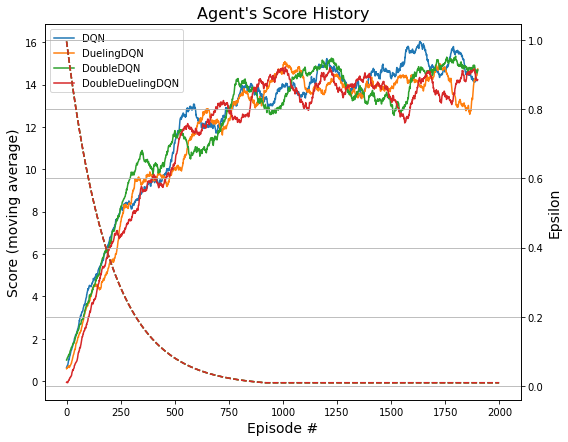

In [8]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_xlabel("Episode #", size=14)
ax1.set_ylabel("Score (moving average)", size=14)
for key, result in results.items():
    moving_average_scores = result["moving_average_scores"]
    ax1.plot(np.arange(len(moving_average_scores)), moving_average_scores, label=key)
ax1.tick_params(axis='y')
ax1.legend(loc="upper left")

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel("Epsilon", size=14)  # we already handled the x-label with ax1
for key, result in results.items():
    epsilons = result["epsilons"]
    ax2.plot(np.arange(len(epsilons)), epsilons, label=key, linestyle='dashed')
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.grid()
plt.title("Agent's Score History", size=16)
plt.show()

In [9]:
env.close()

Given that all approaches have very similar results, we select the simplests, the `DQN` to be our final solution.

In [12]:
# Save the agent weights.
selected_agent = results["DQN"]["agent"]
torch.save(selected_agent.q_network.state_dict(), "./qnetwork.pth")

### Conclusion

We trained four agents to solve the Banana environment, with a combination of DQN, Double DQN and Dueling DQN. They all performed very similarly, with the regular DQN taking to shortest time to "solve" the problem, i.e., having an average return of +13 in 100 consecutive episodes. It is understandable, since Dueling DQN aims at helping with high action-space problems, which is not the case.

### Future Work

For future work, we could explore better replay buffer sampling, with Prioritized Experience Replay [3]. Furthermore, we could run better hyperparameter tunning, changing the network architecture, and also the training parameters, such as the epsilon decay and learning rates.

### References

- [1] https://arxiv.org/pdf/1509.06461.pdf
- [2] https://arxiv.org/pdf/1511.06581.pdf
- [3] https://arxiv.org/pdf/1511.05952.pdf